## Autoencoder to sample the household head age for different household sizes

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim 
from torchvision import datasets, transforms

import os

In [3]:
names = os.listdir('real_samples_of_hh_by_age')

In [4]:
names.remove('.ipynb_checkpoints')

In [5]:
names = [name.split('.')[0] for name in names]

In [7]:
african_countries = [
    'Benin',
    'Botswana',
    'Burkina Faso',
    'Burundi',
    'Ghana',
    'Kenya',
    'Mali',
    'Mauritius',
    'South Africa'
]

In [8]:
new_names = [name for name in names if name not in african_countries]

In [9]:
def get_matrix_normalized(name):
    distr = np.loadtxt('real_samples_of_hh_by_age/' + name + '.txt')
    a1, a2 = distr.shape
    final_distr = np.zeros((a1 + 1, a2 + 1))
    for k in range(1, a2 + 2):
        final_distr[0,  k - 1] = k
    for j in range(1, a1 + 1):
        for k in range(a2 - 1):
            final_distr[j, k] = distr[j - 1, k]
        final_distr[j, a2 - 1] = distr[j - 1, a2 - 1] * 0.7
        final_distr[j, a2] = distr[j - 1, a2 - 1] * 0.3
        
    final_distr = final_distr.T
    for row in final_distr:
        denum = sum(row[1:])
        for i in range(len(row[1:])):
            row[i + 1] = row[i + 1] / denum
    answer = np.array([row[1:] for row in final_distr])
    return answer

In [10]:
dict_learn = {name: get_matrix_normalized(name) for name in names}

In [12]:
transform = transforms.ToTensor()

In [13]:
for key in dict_learn.keys():
    dict_learn[key] = transform(dict_learn[key].reshape(-1, 7 * 11))

In [14]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()        
        self.encoder = nn.Sequential(
            nn.Linear(7 * 11, 5 * 8),
            nn.ReLU(),
            nn.Linear(5 * 8, 1 * 1),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(1 * 1, 5 * 8),
            nn.ReLU(),
            nn.Linear(5 * 8, 7 * 11),
            nn.ReLU()
        )

    def encode(self, x):
        return self.encoder(x)

    def decode(self, y):
        return nn.functional.normalize(input=self.decoder(y)[0].reshape(7, 11), p=1).reshape(1, 77)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = nn.functional.normalize(input=self.decoder(encoded)[0].reshape(7, 11), p=1).reshape(1, 77)
        return decoded

In [15]:
model = Autoencoder()
model.double()
model.load_state_dict(torch.load('models/model_for_hhabysize_1D_L2_23_09.txt', weights_only=True))

<All keys matched successfully>

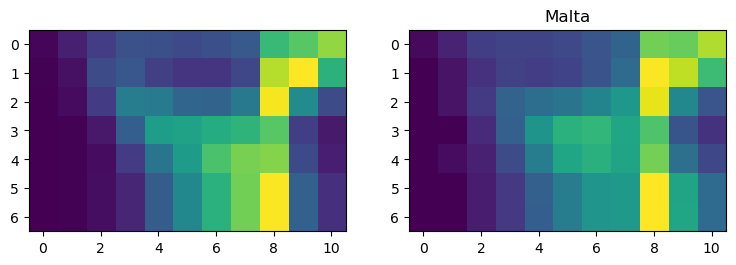

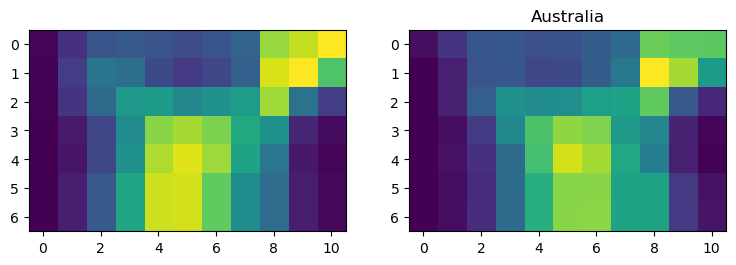

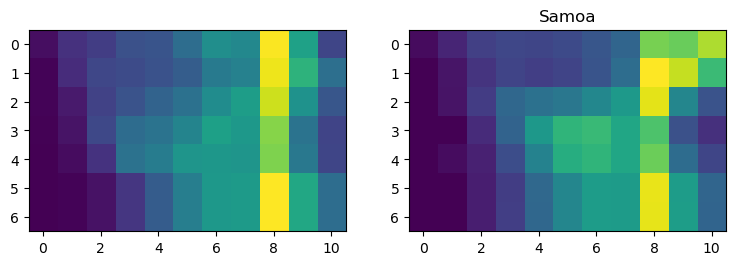

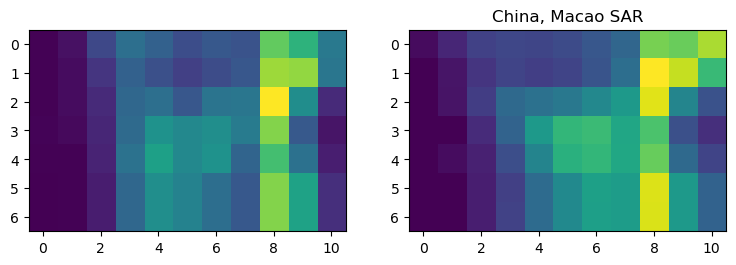

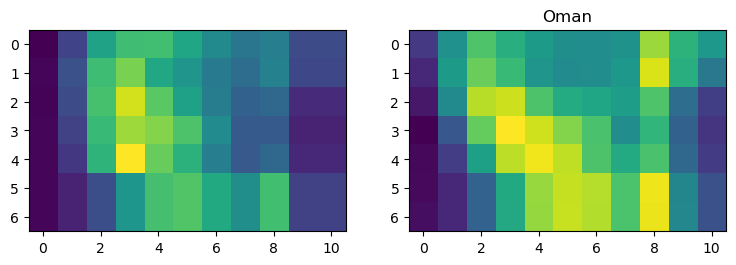

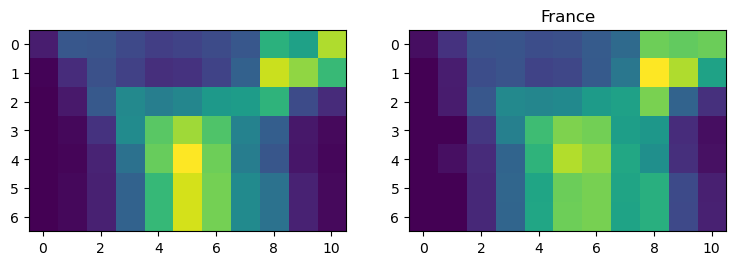

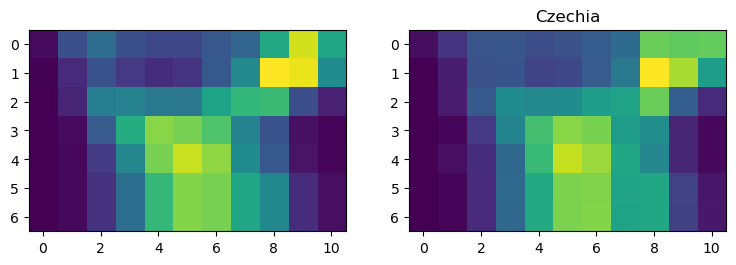

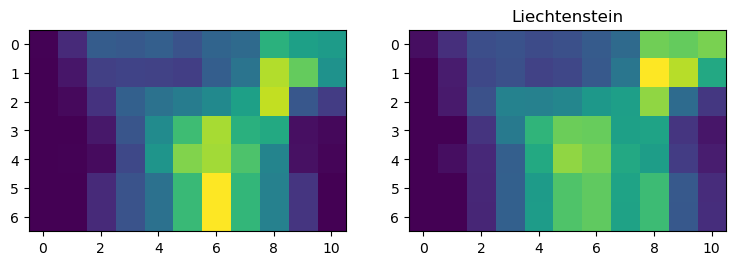

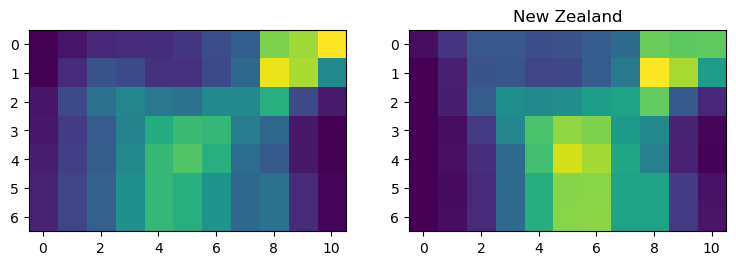

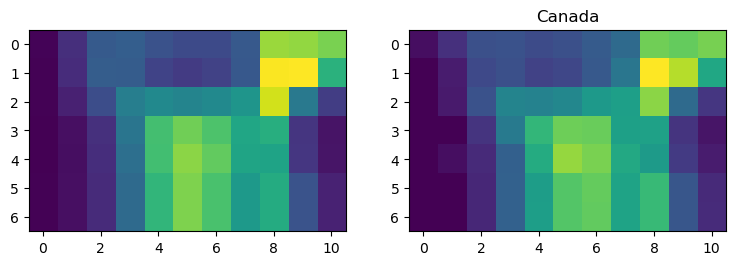

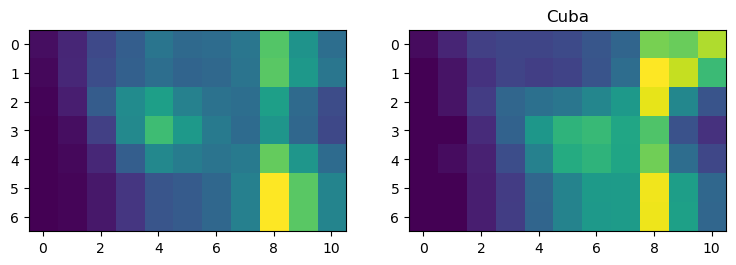

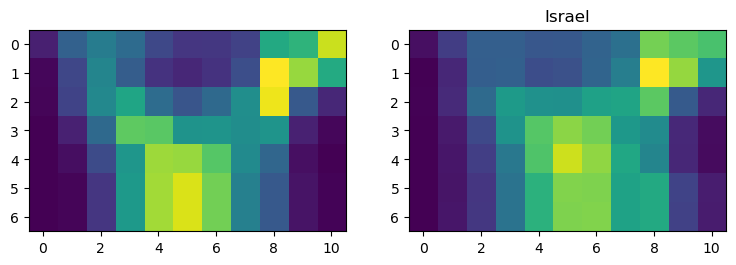

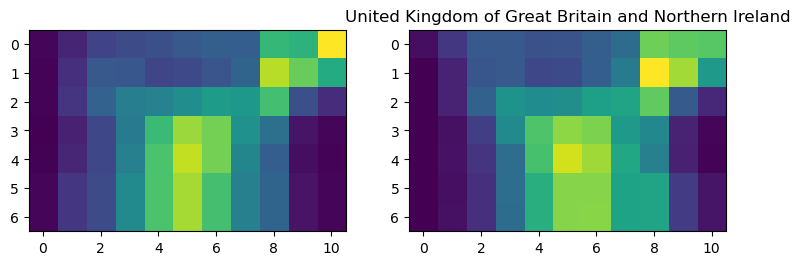

In [16]:
for i in range(80, 93):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
    test = model(dict_learn[names[i]])
    im1 = ax1.imshow([row[:] for row in dict_learn[names[i]].detach().numpy().reshape(7, 11)])
    im2 = ax2.imshow([row[:] for row in test.detach().numpy().reshape(7, 11)])
    ax2.set_title(names[i])
    plt.show()

In [17]:
arr_afr = [model.encode(dict_learn[name]).detach().numpy()[0][0] for name in african_countries]

In [18]:
arr_nonafr = [model.encode(dict_learn[name]).detach().numpy()[0][0] for name in new_names]

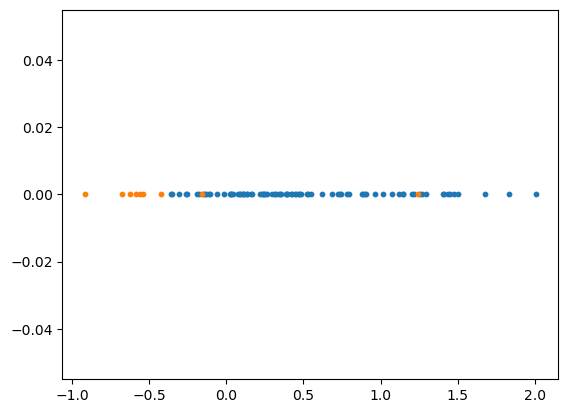

In [19]:
plt.scatter(arr_nonafr, [0 for element in arr_nonafr], s=10)
plt.scatter(arr_afr, [0 for element in arr_afr], s=10)

In [20]:
np.percentile(arr_nonafr, [5, 95])

array([-0.2440368 ,  1.47288357])